In [1]:
################################################################################################################################
############################## PRACTICA DL-CV: Jordi Ortega - IA2 ##############################################################
################################################################################################################################

# 0. Hito 2. Modelo 2D/imágenes

# 1. Entorno -> Importamos librerías y cargamos el dataset
# 2. Train, Validación y Test Dataset -> Partimos el dataset en train, validación y test
# 3. Imagenes Contexto -> Se cargan imágenes para 'tangibilizar' la información con la que trabajaremos
# 4. Red Convolucional -> Lanzamos el algoritmo y conclusiones

In [2]:
################################################################################################################################
############################## ENTORNO PRACTICA ################################################################################
################################################################################################################################

# Al no trabajar desde Jupyter Notebook no necesitamos crear un venv. Colab proporciona un entorno aislado con cada cuaderno.
# Devuelve la ubicación /usr/bin/python3 del sistema operativo Linux (Ubuntu) sobre el que corre Colab.
import sys
print(sys.executable)

# Comprobamos que librerías vienen en el propio entorno
# !pip freeze

# Las librerías especificas que no vienen de origen las instalaremos directamente desde el cuaderno
# !pip install nombre_paquete

import cv2
import numpy
import pandas
import imageio.v3 as io

from tqdm import tqdm
from typing import Optional, Union

/usr/bin/python3


In [3]:
# Cargamos el dataset, miramos volumetría y primeros ajustes
data = pandas.read_csv("dataset.csv", sep = ';')
print(data.shape)
data = data.dropna(subset=['price'])
print(data.shape)

(7199, 72)
(7199, 72)


In [4]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
       'picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'ava

In [5]:
# Comprobamos y limpiamos duplicados
duplicados_id = data[data.duplicated(subset='id', keep='first')]
cantidad_duplicados_id = duplicados_id.drop_duplicates(subset='id').shape[0]

print(f'Número de grupos de registros con ids duplicados: {cantidad_duplicados_id}')

Número de grupos de registros con ids duplicados: 3599


In [6]:
duplicados_completos = data[data.duplicated(keep='first')]
cantidad_duplicados_completos = duplicados_completos.drop_duplicates().shape[0]

print(f'Número de grupos de registros duplicados en todas las columnas: {cantidad_duplicados_completos}')

Número de grupos de registros duplicados en todas las columnas: 3599


In [7]:
# Eliminamos duplicados (manteniendo la primera aparición)
data = data.drop_duplicates(subset='id', keep='first')
print(data.shape)

(3600, 72)


In [8]:
import re
from sklearn.preprocessing import StandardScaler
# Simplificamos el dataset (mismas decisiones que en el modelo tabular pero potencialmente con registros algo distintos cuando carguemos imágenes)
data = data[['picture_url','price']]
data['price'] = data['price'].apply(lambda valor: float(re.sub(r'[\$\,]', '', valor)))
data = data[data['price'] < 801]

<ipython-input-8-6733e3ba2b9e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['price'].apply(lambda valor: float(re.sub(r'[\$\,]', '', valor)))


In [9]:
import numpy as np
# A riesgo de perder calidad de imagen, las limitaremos a 224x224 por 2 motivos principales:
# 1. Agilizar el proceso
# 2. Algunas arquitecturas de redes neuronales convolucionales (CNN) están diseñadas para trabajar con entradas del tamaño seleccionado (por ejemplo: VGG16 y ResNet).

# Reducimos tamaño de entrenamiento para que vaya más rápido
#size_train=50
#data=data[0:size_train]

def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = np.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=numpy.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:
        pass
  return images[downloaded_idxs], downloaded_idxs

urls_imagen = data['picture_url'].tolist()

downloaded_images, successful_indices = download_images(urls_imagen)

print(f'Imágenes descargadas: {len(downloaded_images)}, Índices exitosos: {successful_indices}')
print(f'Forma de las imágenes: {downloaded_images.shape}')
print(downloaded_images.dtype)
print(downloaded_images.min(), downloaded_images.max())

100%|██████████| 3541/3541 [19:04<00:00,  3.09it/s]


Imágenes descargadas: 3074, Índices exitosos: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224

In [10]:
# Normalizamos
downloaded_images = downloaded_images.astype("float32") / 255.

In [11]:
# Seleccionamos registros válidos
data = data.iloc[successful_indices]
data = data.reset_index(drop=True)

In [12]:
# Guardamos los datos para posterior uso/selección
numpy.save('downloaded_images.npy', downloaded_images)
data.to_csv('data.csv', sep=';', index=False)

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!cp downloaded_images.npy /content/drive/MyDrive/downloaded_images.npy
!cp data.csv /content/drive/MyDrive/data.csv

!ls -lah downloaded* data*  # Comprobación

-rw-r--r-- 1 root root 312K Nov 13 15:33 data.csv
-rw-r--r-- 1 root root 8.4M Nov 13 15:13 dataset.csv
-rw-r--r-- 1 root root 1.8G Nov 13 15:32 downloaded_images.npy


In [16]:
# Comprobamos a abrirlos de nuevo
saved_data = pandas.read_csv("/content/drive/MyDrive/data.csv", sep=';')
saved_imgs = numpy.load("/content/drive/MyDrive/downloaded_images.npy")
saved_data.shape, saved_imgs.shape
# Tenemos un dataset con 3074 registros. El primer shape en csv incluye la url y el precio. El segundo shape describe los pixels (224x224) y los canales RGB

((3074, 2), (3074, 224, 224, 3))

In [ ]:
################################################################################################################################
############################## TRAIN, VALIDATION AND TEST DATASET ##############################################################
################################################################################################################################

In [17]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
import re

y = data['price']
X_train, X_test, y_train, y_test = train_test_split(saved_imgs,y, test_size=0.3, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (1720, 224, 224, 3)
Forma de X_val: (431, 224, 224, 3)
Forma de X_test: (923, 224, 224, 3)
Forma de y_train: (1720,)
Forma de y_val: (431,)
Forma de y_test: (923,)


In [18]:
# Normalizamos
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [ ]:
################################################################################################################################
############################## IMAGENES CONTEXTO ###############################################################################
################################################################################################################################

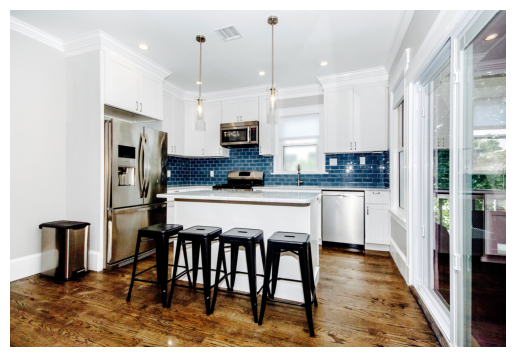

La imagen es en color (RGB), tamaño: 2245x3300


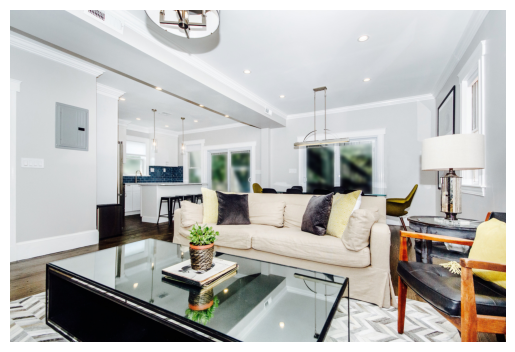

La imagen es en color (RGB), tamaño: 2209x3300


In [19]:
# Variable picture_url: cargaremos las imágenes para ver tamaños y canales...
from skimage import io
import matplotlib.pyplot as plt

image_urls = [
    'https://a0.muscache.com/pictures/prohost-api/Hosting-49127722/original/ffa4d18c-4b3e-490b-bf97-2313ff1c3245.jpeg',
    'https://a0.muscache.com/pictures/prohost-api/Hosting-49127943/original/4d1b5daf-6291-413c-8afd-a772afa4448b.jpeg'
]

for url in image_urls:
    try:
        img = io.imread(url)

        plt.imshow(img)
        plt.axis('off')
        plt.show()

        if img.ndim == 3 and img.shape[2] == 3:
            print(f'La imagen es en color (RGB), tamaño: {img.shape[0]}x{img.shape[1]}')
        else:
            print(f'La imagen NO es en color, tamaño: {img.shape[0]}x{img.shape[1]}')
    except Exception as e:
        print(f'Error al cargar la imagen desde {url}: {e}')

In [ ]:
################################################################################################################################
############################## RED CONVOLUCIONAL ###############################################################################
################################################################################################################################

In [ ]:
# Para el procesamiento de imágenes usaremos un modelo entrenado basado en capas convolucionales empleando posteriormente un clasificador basado en capas densas
# Pasos:
# 1 - Se aplican kernels para obtener tensores intermedios (mapas de características)
# 2 - Estos tensores pasarán por capa densas para producir una salida (predicción 'price')
# 3 - Los 2 pasos anteriores se optimizan usando backpropagation y descenso del gradiente

# Como el 'Feature Extractor' que compone las capas convolucionales y las pooling van de "menos a más" pasando de patrones simples (formas, texturas, colores...) a complejos renunciaremos
# a capas de 'derecha a izquierda'. En un primera iteración simplemente añadimos capa densas, sin alterar otra capas.

# Se decide usar el modelo de ResNet, las conexiones residuales pueden dar estabilidad a la predicción y permite:
# 1 - Extracción de características generales
# 2 - Capacidad de transfer learning

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

base_model = ResNet50(weights="imagenet", include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output = Dense(
    1,
    activation=None,
    kernel_regularizer=regularizers.l2(0.01)
)(x)


model = Model(inputs=base_model.input, outputs=output)

initial_learning_rate = 0.0001
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │ 256)                   │                │                        │
├──────────────────────

 Total params: 23,721,473 (90.49 MB)

 Trainable params: 133,761 (522.50 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
# Entrenamos y evaluamos el modelo con datos de entrenamiento y validación
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Error cuadrático medio en el conjunto de prueba: {test_loss}")

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 1.0074 - mae: 0.7330 - val_loss: 0.9269 - val_mae: 0.7018 - learning_rate: 1.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - loss: 0.8998 - mae: 0.6900 - val_loss: 0.9264 - val_mae: 0.7123 - learning_rate: 1.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 371ms/step - loss: 1.0513 - mae: 0.7467 - val_loss: 0.9196 - val_mae: 0.6820 - learning_rate: 1.0000e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - loss: 1.0985 - mae: 0.7204 - val_loss: 0.9162 - val_mae: 0.6974 - learning_rate: 1.0000e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step - loss: 1.0494 - mae: 0.7096 - val_loss: 0.9138 - val_mae: 0.6988 - learning_rate: 1.0000e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - loss: 0.9462 - mae: 0.7094 - val_loss: 0.9099 - val_mae: 0.6931 - learning_rate: 1.0000e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - loss: 0.9921 - mae: 0.7147 - val_loss: 0.9065 - val_mae: 0.6920

In [22]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Error cuadrático medio en el conjunto de prueba: {loss}")
print(f"MAE en el conjunto de prueba: {mae}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.8373 - mae: 0.6364
Error cuadrático medio en el conjunto de prueba: 0.7872596383094788
MAE en el conjunto de prueba: 0.6173081994056702


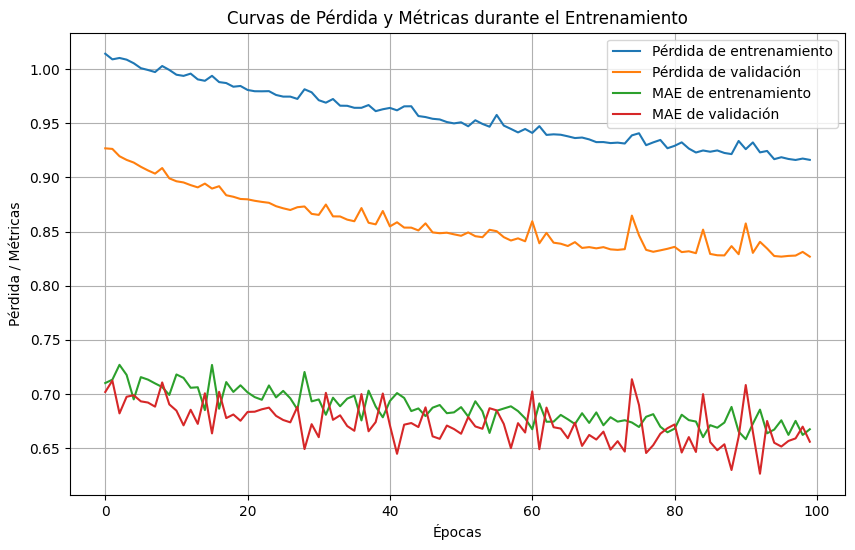

In [23]:
import matplotlib.pyplot as plt

# Graficamos las curvas de pérdida y de mae
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.plot(history.history['mae'], label='MAE de entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de validación')

plt.title('Curvas de Pérdida y Métricas durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida / Métricas')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Conclusiones:
# 1. Con ajuste en leraning rate, aumento de batch size y regularización menor parece que el modelo ha ganado
#    capacidad de aprender. Parece que permite aumentar épocas porque la tendencia es buena.
# 2. Hemos aprovechado todas las capas convolucionales de resnet, convendría probar a descongelar las últimas capas
#    para reentrenarlas en base a nuestro input
# 3. Aceptamos las oscilaciones entendiendo que es un problema de regresión complejo (obtener precio basado en una fotografía)

# Comparativa con versiones anteriores:
# Teníamos un modelo que dejaba de aprender, el early stopping paraba el proceso, y no se obtenían 'buenos' resultados.
# También se apreciaba en la MAE donde las oscilaciones existían sin una tendencia clara (en el modelo actual hay una tendencia descendente).
# A diferencia de la anterior, la versión entregada, incluye capas densas (y vemos que el modelo no está saturado, con más epocas puede seguir aprendiendo)
# y un learning rate más bajo que busca disminuir las oscilaciones. El aumento del batch size también tenía por objetivo conseguir 'líneas' más estables.

In [24]:
# Desnormalizamos las predicciones
predictions = model.predict(X_test)
predictions_desnormalizadas = scaler_y.inverse_transform(predictions.reshape(-1, 1))
print("Predicciones desnormalizadas:", predictions_desnormalizadas)

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step
Predicciones desnormalizadas: [[ 98.83715 ]
 [150.52573 ]
 [162.26184 ]
 [123.13308 ]
 [139.39577 ]
 [131.5317  ]
 [146.0437  ]
 [201.61655 ]
 [185.27719 ]
 [136.89395 ]
 [176.14288 ]
 [128.00154 ]
 [161.13905 ]
 [165.96535 ]
 [171.28853 ]
 [149.69264 ]
 [210.64323 ]
 [172.81029 ]
 [211.86977 ]
 [159.94785 ]
 [145.58917 ]
 [187.11491 ]
 [167.64131 ]
 [171.46924 ]
 [156.2541  ]
 [147.65265 ]
 [175.31058 ]
 [145.9422  ]
 [187.17177 ]
 [149.10803 ]
 [157.86107 ]
 [112.4059  ]
 [117.70433 ]
 [153.29065 ]
 [151.33629 ]
 [153.66083 ]
 [188.9517  ]
 [168.54857 ]
 [152.24269 ]
 [225.4157  ]
 [182.01137 ]
 [168.868   ]
 [134.39319 ]
 [155.33417 ]
 [193.20866 ]
 [165.63023 ]
 [190.83044 ]
 [169.88568 ]
 [203.35664 ]
 [135.24908 ]
 [197.6381  ]
 [177.90295 ]
 [200.53084 ]
 [144.11937 ]
 [182.35889 ]
 [188.28816 ]
 [164.19789 ]
 [211.73276 ]
 [157.84886 ]
 [110.29019 ]
 [141.14166 ]
 [171.13283 ]
 [165.29773 ]
 [116.599   ]
 [142.54059 ]
 [176.27957 ]
 [126

In [25]:
# 'Tangibilizamos algunos casos para ver los errores cometidos
y_test_desnormalizado = scaler_y.inverse_transform(y_test.reshape(-1, 1))
for i in range(5):
    print(f"Predicción desnormalizada {i+1}: {predictions_desnormalizadas[i][0]} | Precio real: {y_test_desnormalizado[i][0]}")


Predicción desnormalizada 1: 98.83715057373047 | Precio real: 80.0
Predicción desnormalizada 2: 150.52572631835938 | Precio real: 85.0
Predicción desnormalizada 3: 162.2618408203125 | Precio real: 145.0
Predicción desnormalizada 4: 123.1330795288086 | Precio real: 35.0
Predicción desnormalizada 5: 139.39576721191406 | Precio real: 97.0


In [26]:
from sklearn.metrics import mean_absolute_error

predictions_desnormalizadas = scaler_y.inverse_transform(predictions.reshape(-1, 1))
y_test_desnormalizado = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculamos el MAE en euros
mae_test_euros = mean_absolute_error(y_test_desnormalizado, predictions_desnormalizadas)
print(f"El MAE en el conjunto de prueba es de {mae_test_euros:.2f} euros")

El MAE en el conjunto de prueba es de 79.66 euros


In [27]:
model.save('/content/drive/MyDrive/modelo_pictures_2.keras')